# Usermore soap case study

Guilherme Fernandes e Lauro Solia

In [1]:
from pprint import pprint

import gurobipy
from gurobipy import Model, GRB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Defining the sets

In [ ]:
plants = [
    "Covington",
    "New York",
    "Arlington",
    "Long Beach",
]

existing_warehouses = [
    "Atlanta",
    "Boston",
    "Buffalo",
    "Chicago",
    "Cleveland",
    "Davenport",
    "Detroit",
    "Grand Rapids",
    "Greensboro",
    "Kansas City",
    "Baltimore",
    "Memphis",
    "Milwaukee",
    "Orlando",
    "Pittsburgh",
    "Portland",
    "W Sacramento",
    "W Chester",
]

warehouses = plants + existing_warehouses

In [ ]:
print("Number of plants: ", len(plants))
print("Number of existing warehouses: ", len(existing_warehouses))
# print("Number of potential warehouses: ", len(potential_warehouses))
print("Number of total available warehouses for this case: ", len(warehouses))
print("Obs.: Each plant is also an existing warehouse")

Number of plants:  4
Number of existing warehouses:  18
Number of potential warehouses:  26
Number of total available warehouses for this case:  22
Obs.: Each plant is also an existing warehouse


## 2. Parameters

### Demand

In [4]:
# read state demands from Figure 1
state_demand = {
    # West region:
    "WA": 32_437,  # Washington
    "OR": 31_365,  # Oregon
    "CA": 135_116,  # California
    "NV": 16755,  # Nevada
    "AZ": 9063,  # Arizona
    "ID": 7153,  # Idaho
    # Northwest region:
    "UT": 9001,  # Utah
    "MT": 4140,  # Montana
    "ND": 5703,  # North Dakota
    "WY": 1004,  # Wyoming
    "CO": 11147,  # Colorado
    "SD": 1049,  # South Dakota
    "NE": 7347,  # Nebraska
    "KS": 6961,  # Kansas
    "MN": 5633,  # Minnesota
    "IA": 32175,  # Iowa
    "MO": 41680,  # Missouri
    # Southwest region:
    "NM": 3536,  # New Mexico
    "TX": 80438,  # Texas
    "OK": 13517,  # Oklahoma
    "AR": 4910,  # Arkansas
    "LA": 15011,  # Louisiana
    # Midwest region:
    "WI": 37448,  # Wisconsin
    "IL": 72839,  # Illinois
    "MI": 105_181,  # Michigan
    "IN": 43994,  # Indiana
    "KY": 3870,  # Kentucky
    "OH": 155_123,  # Ohio
    # Northeast region:
    "ME": 15829,  # Maine
    "NH": 4546,  # New Hampshire
    "RI": 17000,  # Rhode Island
    "NJ": 21154,  # New Jersey
    "NY": 160_917,  # New York
    "PA": 65108,  # Pennsylvania
    "CT": 26_187,  # Connecticut
    "MA": 37087,  # Massachusetts
    "VA": 17667,  # Virginia
    "WV": 9168,  # West Virginia
    "MD": 19_284,  # Maryland
    "VT": 2_928,  # Vermont
    "DE": 3_044,  # Delaware
    # Southeast region:
    "TN": 42_479,  # Tennessee
    "MS": 15_205,  # Mississippi
    "AL": 15_835,  # Alabama
    "GA": 29_559,  # Georgia
    "FL": 46_405,  # Florida
    "SC": 5_680,  # South Carolina
    "NC": 28_348,  # North Carolina
}

In [5]:
S = state_demand  # Sales
total_demand = sum(S.values())

print("Total states number: ", len(S))
print("Total demand: ", total_demand)
print("Each state represents a demand center")

# NOTE: Valor total deve ser 1_477_026, então precisei ajustar NY (que nao tem na foto) pra bater o valor final.

Total states number:  48
Total demand:  1477026
Each state represents a demand center


In [6]:
demand_centers = [f"{s}" for s in state_demand.keys()]

# pprint(demand_centers)

### Capacities

In [7]:
# Plants current capacities C[p]
C = {
    "Covington": 620_000,
    "New York": 430_000,
    "Arlington": 300_000,
    "Long Beach": 280_000,
}

In [8]:
# Warehouse/Plant stocking capacities C'[p]
# (plants have capacity to stock, but the public warehouses do not)
C_prime = {
    "Covington": 450_000,
    "New York": 380_000,
    "Arlington": 140_000,
    "Long Beach": 180_000,
}

### Distances

In [9]:
# Distance matrices (in miles)
#     d_pw[p][w] = distance plant → warehouse
#     d_wd[w][d] = distance warehouse → demand center

df_pw = pd.read_excel(
    "../distances/distance_matrix.xlsx",
    sheet_name="d_pw",
    index_col=0,
)
df_wd = pd.read_excel(
    "../distances/distance_matrix.xlsx",
    sheet_name="d_ws",
    index_col=0,
)

d_pw = df_pw.to_dict()
d_wd = df_wd.to_dict()

In [10]:
# print("Distance matrices:")
# print("d_pw (plant to warehouse):")
# pprint(d_pw)
# print("d_wd (warehouse to demand center):")
# pprint(d_wd)


### Costs

In [11]:
# Unit production cost (variable production cost)
rho = {
    "Covington": 21.0,
    "New York": 19.9,
    "Arlington": 21.6,
    "Long Beach": 21.1,
}

In [12]:
# Inbound cost c_in[p][w] = 0.92 + 0.0034*d_pw
# Represents costs from plants to warehouses
c_in = {
    p: {w: 0.92 + 0.0034 * d_pw[p][w.replace("-", "")] for w in warehouses}
    for p in plants
}

# c_in

In [13]:
# Ler tabela 3 do excel
table3 = pd.read_excel("../misc/tabelas.xlsx", sheet_name="table3")

table3.head()

,Warehouse No.,Storage ($/$),Handling ($/cwt),Stock Order Processing ($/order),Stock Order Size,Customer Order Processing ($/order),Customer Order size (cwt/order),Local delivery rate ($/cwt)
0,1,0.0672,0.46,18,400,1.79,9.05,1.90
1,2,0.0567,0.54,18,400,1.74,10.92,3.89
2,3,0.0755,0.38,18,400,2.71,11.59,2.02
3,4,0.0735,0.59,18,400,1.74,11.30,4.31
4,5,0.0946,0.50,18,401,0.83,9.31,1.89


In [14]:
# NOTE: usamos esse código so pra checar se existem valores abaixo de 30 milhas
# for k, v in d_ws.items():
#     for k2, v2 in v.items():
#         if v2 <= 30:
#             print(k, k2, v2)

In [15]:
# Outbound cost c_out[w][j]:
# Custo de enviar do warehouse para o demand center

local_rate = {i: v for i, v in enumerate(table3["Local delivery rate ($/cwt)"])}

c_out = {}
for i, w in enumerate(warehouses):
    # w = w.replace("-", "")
    c_out[w] = {}
    for s in demand_centers:
        d = d_wd[w][s]
        if d <= 30:
            # if d<=30: use local cartage rate from Table 3
            c_out[w][s] = local_rate[i]
        else:
            # else use 5.45 + 0.0037*d
            c_out[w][s] = 5.45 + 0.0037 * d

# c_out

In [16]:
# Conversão de unidades:
# Quanto representa 1 cwt. em $?
# Dividimos as vendas totais ($) pela demand total (cwt)
# Gamma = 160_000_000 /(1_477_026 + 7500_00)  # ($ / cwt)
# Gamma

In [17]:
# Custo de estocagem do armazém w (Storage rate)
tau = {}

for i, w in enumerate(warehouses):
    # Fiz o casting para evitar o np.float64 nos prints, mas nao precisava
    tau[w] = float(table3["Storage ($/$)"][i])

In [18]:
# Custo de handling do armazém w (epsilon)

epsilons = {}

for i, w in enumerate(warehouses):
    epsilons[w] = float(table3["Handling ($/cwt)"][i])

In [19]:
# gamma

gammas = {}

for i, w in enumerate(warehouses):
    gammas[w] = float(table3["Stock Order Processing ($/order)"][i])

In [20]:
# delta

deltas = {}

for i, w in enumerate(warehouses):
    deltas[w] = float(table3["Stock Order Size"][i])

In [21]:
# omega

omegas = {}

for i, w in enumerate(warehouses):
    omegas[w] = float(table3["Customer Order size (cwt/order)"][i])

In [22]:
# phi

phi = {}
for i, w in enumerate(warehouses):
    phi[w] = float(table3["Customer Order Processing ($/order)"][i])

## 3. Defining the model

In [23]:
m = Model(name="UsemoreWarehousing")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-11


### Indices

In [24]:
print(plants)
print(warehouses)
# NOTE: tem que ver se o "New York-" não vai dar bug quando permitirmos os potentials
print(demand_centers)

['Covington', 'New York', 'Arlington', 'Long Beach']
['Covington', 'New York', 'Arlington', 'Long Beach', 'Atlanta', 'Boston', 'Buffalo', 'Chicago', 'Cleveland', 'Davenport', 'Detroit', 'Grand Rapids', 'Greensboro', 'Kansas City', 'Baltimore', 'Memphis', 'Milwaukee', 'Orlando', 'Pittsburgh', 'Portland', 'W Sacramento', 'W Chester']
['WA', 'OR', 'CA', 'NV', 'AZ', 'ID', 'UT', 'MT', 'ND', 'WY', 'CO', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'NM', 'TX', 'OK', 'AR', 'LA', 'WI', 'IL', 'MI', 'IN', 'KY', 'OH', 'ME', 'NH', 'RI', 'NJ', 'NY', 'PA', 'CT', 'MA', 'VA', 'WV', 'MD', 'VT', 'DE', 'TN', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC']


### Decision variables

In [25]:
# Se eu uso um armazém: Z[w] = 1
Z = m.addVars(warehouses, vtype=GRB.BINARY, name="z")

# Quanto de volume mando de p para w
X = m.addVars(plants, warehouses, vtype=GRB.CONTINUOUS, name="x")

# Quanto de volume mando de w para d
Y = m.addVars(warehouses, demand_centers, vtype=GRB.CONTINUOUS, name="y")

## 4. Objective Function

### Define all the costs components

In [26]:
# inbound transport (from plants to warehouses)
# NOTE: coloquei esse if w != p porque nao ha custo de transporte para levar da planta para o seu próprio armazém
inbound_transport_cost = gurobipy.quicksum(
    c_in[p][w] * X[p, w] for p in plants for w in warehouses if w != p
)

In [27]:
# outbound transport (from warehouses to demand nodes)
outbound_transport_cost = gurobipy.quicksum(
    c_out[w][d] * Y[w, d] for w in warehouses for d in demand_centers
)

In [28]:
# production cost
production_costs = gurobipy.quicksum(
    rho[p] * (X[p, w]) for p in plants for w in warehouses
)

In [29]:
# Storage cost in warehouses
# Para cada armazém, calcula o custo de estocagem individualmente e soma todos

m.Params.NonConvex = 2

storage_pow = {}
storage_costs = []

for w in warehouses:
    # total de saída do armazém w
    totX_w = m.addVar(name=f"totX_{w}")

    m.addConstr(
        totX_w == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"define_totX_{w}",
    )

    # variável para totX_w^0.58
    storage_pow[w] = m.addVar(name=f"storage_pow_{w}")

    m.addGenConstrPow(totX_w, storage_pow[w], 0.58, name=f"storage_pow_{w}")

    # custo de estocagem para o armazém w
    storage_costs.append(26 * 11.3 * storage_pow[w] * tau[w])

# soma total dos custos de estocagem
storage_costs = gurobipy.quicksum(storage_costs)

Set parameter NonConvex to value 2


In [30]:
# INVENTORY
inventory_pow = {}
inventory_costs = []

for w in warehouses:
    # total de saída do armazém w
    totX_w = m.addVar(name=f"totX_{w}")

    m.addConstr(
        totX_w == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"define_totX_{w}",
    )

    # variável para totX_w^0.58
    inventory_pow[w] = m.addVar(name=f"inventory_pow_{w}")

    m.addGenConstrPow(totX_w, inventory_pow[w], 0.58, name=f"inventory_pow_{w}")

    # custo de Inventory para o armazém w
    inventory_costs.append(26 * 0.12 * 11.3 * inventory_pow[w])

# soma total dos custos de estocagem
inventory_costs = gurobipy.quicksum(inventory_costs)

In [31]:
# custo de handling nos armazéns
handling_costs = gurobipy.quicksum(
    2 * Z[w] * X[p, w] * epsilons[w] for p in plants for w in warehouses
)

In [32]:
# custo de processamento do pedido de estoque
stock_order_processing_costs = gurobipy.quicksum(
    Z[w] * X[p, w] * (gammas[w] / deltas[w]) for p in plants for w in warehouses
)

In [33]:
# custo de processamento do pedido do cliente
customer_order_processing_costs = gurobipy.quicksum(
    Z[w] * Y[w, d] * (phi[w] / omegas[w]) for w in warehouses for d in demand_centers
)

### Define the objective function

In [34]:
m.setObjective(
    inbound_transport_cost
    + outbound_transport_cost
    + production_costs
    + storage_costs
    + inventory_costs
    + handling_costs
    + stock_order_processing_costs
    + customer_order_processing_costs,
    sense=GRB.MINIMIZE,
)

## Constraints

### Service level

In [35]:
# Porcentagem de volume atendidos a uma distância menor que SERVICE_LEVEL_DISTANCE milhas

service_level_30 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 30
)
service_level_100 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 100
)
service_level_300 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 300
)
service_level_600 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 600
)
service_level_1000 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 1000
)
service_level_1500 = gurobipy.quicksum(
    Y[w, d] / total_demand
    for w in warehouses
    for d in demand_centers
    if d_wd[w][d] <= 1500
)


m.addConstr(
    service_level_300 >= 93 / 100,
    name="service_level",
)

<gurobi.Constr *Awaiting Model Update*>

In [36]:
# Distancias medianas de um armazém para os centros de demanda

# for w in d_wd.keys():
#     q1 = np.percentile(list(d_wd[w].values()), 95)
#       print(f"{w:>20} {q1:>7.2f}")

### Demand

In [37]:
# Demand satisfaction

for d in demand_centers:
    m.addConstr(
        gurobipy.quicksum(Y[w, d] for w in warehouses) == S[d],
        name=f"demand_{d}",
    )

### Production

In [38]:
# Plant production capacity

for p in plants:
    m.addConstr(
        gurobipy.quicksum(X[p, w] for w in warehouses) <= C[p],
        name=f"plantCap_{p}",
    )

### Capacity

In [39]:
# restrição dos 10400

for w in warehouses:
    # Um armazém só pode ser aberto se houver demanda de pelo menos 10_400 cwt
    m.addConstr(
        gurobipy.quicksum(Y[w, d] for d in demand_centers) >= 10_400 * Z[w],
        name=f"minThroughput_{w}",
    )

In [40]:
# restrições de armazenagem de cada planta

for p1 in plants:
    m.addConstr(
        gurobipy.quicksum(X[p2, p1] for p2 in plants) <= C_prime[p1],
        name=f"plantStorageCap_{p1}",
    )

### Flow balance

In [41]:
# Flow balance at each warehouse (está quebrando o código...)

for w in warehouses:
    # Tudo que entra no armazém deve ser igual a tudo que sai
    m.addConstr(
        gurobipy.quicksum(X[p, w] for p in plants)
        == gurobipy.quicksum(Y[w, d] for d in demand_centers),
        name=f"flowBalance_{w}",
    )

### Flow conservation

In [42]:
M = total_demand

In [43]:
# Restrições de Z (só posso usar um armazém se ele estiver aberto)
for w in warehouses:
    for p in plants:
        # NOTE: the C[p] here is working as the big-M
        m.addConstr(
            X[p, w] <= M * Z[w],
            name=f"openWarehouse_{w},{p}",
        )
    for d in demand_centers:
        # NOTE: the S[d] here is working as the big-M
        m.addConstr(
            Y[w, d] <= M * Z[w],
            name=f"openWarehouse_{w},{d}",
        )

## Solver

In [44]:
# NOTE: precisou ser o formato .rlp pois algumas variáveis têm espaço
m.write("model-baseline-p1.rlp")
m.write("model-baseline-p1.lp")

In [45]:
m.params.TimeLimit = 600  # seconds

Set parameter TimeLimit to value 600


In [46]:
m.presolve()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Presolve added 106 rows and 3322 columns
Presolve time: 0.05s


<gurobi.Model MIP instance UsemoreWarehousing_pre: 2539 constrs, 5720 vars, Parameter changes: TimeLimit=600.0, Username=(user-defined), NonConvex=2>

In [47]:
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1289 rows, 1254 columns and 7920 nonzeros
Model fingerprint: 0x4330c1f4
Model has 1144 quadratic objective terms
Model has 44 general constraints
Variable types: 1232 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [7e-07, 1e+06]
  Objective range  [2e+00, 3e+02]
  QObjective range [2e-01, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 6e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve added 106 rows and 3322 columns
Presolve time: 0.05s
Presolved: 2539 rows, 5720 columns, 18222 nonzeros
Presolved model has 44 SOS constraint(s)
Variable types: 5698 continuous, 22 integer (22 binary)

Root relaxation: 

In [48]:
m.printStats()


Statistics for model UsemoreWarehousing:
  Linear constraint matrix    : 1289 Constrs, 1254 Vars, 7920 NZs
  Variable types              : 1232 Continuous,
22 Integer (22 Binary)
  General constraints         : 44 Constrs
  Matrix coefficient range    : [ 6.77036e-07, 1.47703e+06 ]
  Objective coefficient range : [ 1.73, 291.156 ]
  Variable bound range        : [ 1, 1 ]
  RHS coefficient range       : [ 0.93, 620000 ]


In [49]:
m.printQuality()


Solution quality statistics for model UsemoreWarehousing :
  Maximum violation:
    Bound       : 0.00000000e+00
    Constraint  : 1.10591024e+00 (storage_pow_Long Beach)
    Integrality : 0.00000000e+00


## Visualize results

### Costs

In [50]:
# Print the solution objective value
print(f"Objective function final value: ${m.objVal:,.2f}")
# $46,679,920.32
# $43,295,679.23 (SL = 67%  - 300 mi)

Objective function final value: $44,075,426.99


In [51]:
def display_cost_components():
    """Calculate and display all cost components"""

    # Get cost values from the model
    costs = {
        "Inbound transport cost": inbound_transport_cost.getValue(),
        "Outbound transport cost": outbound_transport_cost.getValue(),
        "Production costs": production_costs.getValue(),
        "Storage costs": storage_costs.getValue(),
        "Handling costs": handling_costs.getValue(),
        "Stock order processing costs": stock_order_processing_costs.getValue(),
        "Customer order processing costs": customer_order_processing_costs.getValue(),
        "Inventory Carrying Costs": inventory_costs.getValue(),
    }

    # Calculate total cost
    total = sum(costs.values())

    # Print the cost components in a formatted table
    print("\n" + "=" * 65)
    print(f"{'COST BREAKDOWN':^65}")
    print("=" * 65)
    print(f"{'Cost Component':<30} {'Amount ($)':>18} {'Percentage':>12}")
    print("-" * 65)

    try:
        for name, value in costs.items():
            percentage = (value / total) * 100
            print(f"{name:<32} ${value:>17,.2f} {percentage:>11.2f}%")
    except ZeroDivisionError:
        pass

    print("-" * 65)
    print(f"{'TOTAL COST':<32} ${total:>17,.2f} {100:>11.2f}%")
    print("=" * 65)


# Call the function to display costs
display_cost_components()

# 43,295,679.23

# Distancia (x) | Nivel de servico (y) | custo total (z)


                         COST BREAKDOWN                          
Cost Component                         Amount ($)   Percentage
-----------------------------------------------------------------
Inbound transport cost           $     1,455,796.95        3.30%
Outbound transport cost          $     8,902,054.22       20.20%
Production costs                 $    30,678,860.60       69.61%
Storage costs                    $       374,333.90        0.85%
Handling costs                   $     1,887,934.30        4.28%
Stock order processing costs     $        65,614.38        0.15%
Customer order processing costs  $       334,415.75        0.76%
Inventory Carrying Costs         $       376,416.90        0.85%
-----------------------------------------------------------------
TOTAL COST                       $    44,075,426.99      100.00%


### Locations

In [52]:
open_w = [w for w in warehouses if Z[w].X > 0.1]
closed_w = [w for w in warehouses if Z[w].X < 0.1]

print(f"Number of open warehouses 🏭: {len(open_w)} ")
print(f"Number of closed warehouses 🔒: {len(closed_w)} ")

# Calculate percentage of open warehouses
percentage_open = (len(open_w) / len(warehouses)) * 100
print(f"Percentage of warehouses open: {percentage_open:.1f}% 📊")


print("\n------------------ Warehouse openings ------------------")
for w in open_w:
    volume = X.sum("*", w).getValue()
    print(f" Open warehouse at {w:>15} ({volume:>9.2f} cwt)")

if len(closed_w) > 0:
    print("\n------------------ Warehouse closings ------------------")
    for w in closed_w:
        volume = X.sum("*", w).getValue()
        print(f" Closed warehouse at {w:>13} ({volume:>9.2f} cwt)")

Number of open warehouses 🏭: 15 
Number of closed warehouses 🔒: 7 
Percentage of warehouses open: 68.2% 📊

------------------ Warehouse openings ------------------
 Open warehouse at       Covington (270451.82 cwt)
 Open warehouse at        New York (337971.00 cwt)
 Open warehouse at       Arlington (136645.00 cwt)
 Open warehouse at      Long Beach (180000.00 cwt)
 Open warehouse at         Atlanta ( 51074.00 cwt)
 Open warehouse at          Boston ( 15829.00 cwt)
 Open warehouse at       Davenport ( 37102.18 cwt)
 Open warehouse at         Detroit (105181.00 cwt)
 Open warehouse at      Greensboro ( 28348.00 cwt)
 Open warehouse at     Kansas City ( 46579.00 cwt)
 Open warehouse at       Baltimore ( 36951.00 cwt)
 Open warehouse at         Memphis ( 10400.00 cwt)
 Open warehouse at       Milwaukee (110287.00 cwt)
 Open warehouse at         Orlando ( 46405.00 cwt)
 Open warehouse at        Portland ( 63802.00 cwt)

------------------ Warehouse closings ------------------
 Closed wareh

### Service level results

In [53]:
# Calculate and print cumulative service level curve

service_levels = [
    (30, service_level_30.getValue()),
    (100, service_level_100.getValue()),
    (300, service_level_300.getValue()),
    (600, service_level_600.getValue()),
    (1000, service_level_1000.getValue()),
    (1500, service_level_1500.getValue()),
]

print("=" * 60)
print(f"{'Service Level Curve':^60}")
print("=" * 60)
print(f"{'Distance (miles)':<20} {'Service Level (%)':>35}")
print("-" * 60)
for dist, level in service_levels:
    print(f"{dist:>20} {100 * level:25.2f}")
# print("-" * 60)

                    Service Level Curve                     
Distance (miles)                       Service Level (%)
------------------------------------------------------------
                  30                      1.31
                 100                     34.25
                 300                     93.00
                 600                     96.73
                1000                     99.27
                1500                    100.00


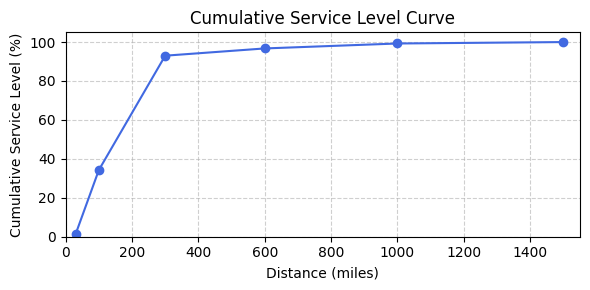

In [54]:
# Optionally, plot the cumulative curve if matplotlib is available

distances = [d for d, _ in service_levels]
levels = [100 * sl for _, sl in service_levels]

plt.figure(figsize=(6, 3))
plt.plot(distances, levels, marker="o", linestyle="-", color="royalblue")
plt.title("Cumulative Service Level Curve")
plt.xlabel("Distance (miles)")
plt.ylabel("Cumulative Service Level (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.ylim(0, 105)
plt.xlim(0, max(distances) + 50)
plt.tight_layout()
plt.show()

In [55]:
# TODO: Salvar os open warehouses em um arquivo


### Production

In [56]:
plant_production = {}

for p in plants:
    plant_production[p] = sum(X[p, w].X for w in warehouses if Z[w].X > 0.1)

print("\n------------------ Plant production ----------------------")
total_production = sum(plant_production.values())
for p in plants:
    percentage = (plant_production[p] / total_production) * 100
    print(
        f" Plant {p:>15} production: {plant_production[p]:,.2f} cwt ({percentage:>4.1f}%)"
    )
print("----------------------------------------------------------")
print(f"Total production: {total_production:,.2f} cwt")


------------------ Plant production ----------------------
 Plant       Covington production: 620,000.00 cwt (42.0%)
 Plant        New York production: 430,000.00 cwt (29.1%)
 Plant       Arlington production: 183,224.00 cwt (12.4%)
 Plant      Long Beach production: 243,802.00 cwt (16.5%)
----------------------------------------------------------
Total production: 1,477,026.00 cwt


### Flows

In [57]:
print("\n---------- Plant → Warehouse flows -------------")
for p, w in X.keys():
    if X[p, w].X > 1e-6:
        print(f" {p:>15} → {w:<15} = {X[p, w].X:>6.0f} cwt")


---------- Plant → Warehouse flows -------------
       Covington → Covington       = 270452 cwt
       Covington → Atlanta         =  51074 cwt
       Covington → Davenport       =  37102 cwt
       Covington → Detroit         = 105181 cwt
       Covington → Memphis         =  10400 cwt
       Covington → Milwaukee       = 110287 cwt
       Covington → Orlando         =  35504 cwt
        New York → New York        = 337971 cwt
        New York → Boston          =  15829 cwt
        New York → Greensboro      =  28348 cwt
        New York → Baltimore       =  36951 cwt
        New York → Orlando         =  10901 cwt
       Arlington → Arlington       = 136645 cwt
       Arlington → Kansas City     =  46579 cwt
      Long Beach → Long Beach      = 180000 cwt
      Long Beach → Portland        =  63802 cwt


In [58]:
print("\n------- Warehouse → Demand flows ---")
for w, j in Y.keys():
    if Y[w, j].X > 1e-6:
        print(f" {w:>16} → {j}: {Y[w, j].X:>6.0f} cwt")


------- Warehouse → Demand flows ---
        Covington → ND:   5703 cwt
        Covington → MN:   5633 cwt
        Covington → MO:   4482 cwt
        Covington → IN:  43994 cwt
        Covington → KY:   3870 cwt
        Covington → OH: 155123 cwt
        Covington → WV:   9168 cwt
        Covington → TN:  42479 cwt
         New York → NH:   4546 cwt
         New York → RI:  17000 cwt
         New York → NJ:  21154 cwt
         New York → NY: 160917 cwt
         New York → PA:  65108 cwt
         New York → CT:  26187 cwt
         New York → MA:  37087 cwt
         New York → VT:   2928 cwt
         New York → DE:   3044 cwt
        Arlington → MT:   1228 cwt
        Arlington → WY:   1004 cwt
        Arlington → CO:  11147 cwt
        Arlington → SD:   1049 cwt
        Arlington → NM:   3536 cwt
        Arlington → TX:  80438 cwt
        Arlington → OK:  13517 cwt
        Arlington → AR:   4910 cwt
        Arlington → LA:  15011 cwt
        Arlington → MS:   4805 cwt
       Long Beach